Check the quality of spike train generation and augmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen, arb_spk_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [ ]:
data[data['ptl_idx']==3].head()

In [ ]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen(scale_left=0.05, scale_right=0.1, tau_left=40, tau_right=20, scale=0.1)
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bi_exp_ker(), label='ker_post')
plt.legend()

In [ ]:
# Generate data
ptl_list = [1]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10])

In [ ]:
spk_pairs.shape

In [ ]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    loci_pre.append(loci_pre_tmp)
    loci_post.append(loci_post_tmp)
    dt_mean.append(np.mean(loci_pre_tmp - loci_post_tmp))

sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [ ]:
def raster(event_times_list, trial_length,  **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial[trial_length]*2, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

In [ ]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,5)
ax = raster(loci_pre_2, trial_length)
ax = raster(loci_post_2,trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
fig.show()

In [ ]:
# Generate data
ptl_list = [2,4]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10,10])
spk_pairs.shape

In [ ]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if len(loci_pre_tmp) == len(loci_post_tmp) * 2:   # Pre-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp - loci_pre_tmp[index_pre]))
    elif len(loci_post_tmp) == len(loci_pre_tmp) * 2:   # Post-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post] - loci_pre_tmp))
    else:
        print('Wrong length!!')
        
sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [ ]:
fig = plt.figure(figsize=(15, 8))
trial_length1 = np.arange(0,10)
trial_length2 = np.arange(0,5)
ax = raster(loci_pre_2, trial_length1)
ax = raster(loci_post_2, trial_length2, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [ ]:
# Generate data
ptl_list = [3]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10])
spk_pairs.shape

In [ ]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
# spk_pairs.shape[0]
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if loci_pre_tmp[0] < loci_post_tmp[0]:  # Pre-post-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_pre+1] - loci_pre_tmp[index_pre]) * -1)
    elif loci_pre_tmp[0] > loci_post_tmp[0]:   # Post-pre-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post+1] - loci_post_tmp[index_post]))
        
sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [ ]:
loci_post_tmp 

In [ ]:
loci_pre_tmp

In [ ]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,10)
ax = raster(loci_pre_2[:100], trial_length)
ax = raster(loci_post_2[:100], trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [ ]:
# Generate data
ptl_list = [5]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10])
spk_pairs.shape

In [ ]:
data[data['ptl_idx']==5]

In [ ]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    loci_pre.append(loci_pre_tmp)
    loci_post.append(loci_post_tmp)
    dt_mean.append(np.mean(loci_pre_tmp - loci_post_tmp))

sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [ ]:
loci_pre_tmp

In [ ]:
loci_post_tmp

In [ ]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,20)
ax = raster(loci_pre_2[:500], trial_length)
ax = raster(loci_post_2[:500], trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,3000])
fig.show()

### Generate STDP spike trains and save

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


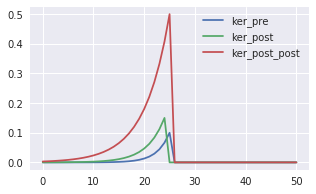

In [4]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()
ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=5, scale=0.1, shift=-1)
ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=7, scale=0.15)
ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=10, scale=0.5, shift=-1)
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()

In [5]:
# Generate data
ptl_list = [1]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data[data['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

    spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
STDP_pairs, _ = arb_w_gen(df=data_select, ptl_list=[1,2,3,4], spk_len=spk_len, kernel=ker_test, aug_times=[10], net_type='triplet')

### Generate hippocampal spike trains and save

In [6]:
# Generate data
ptl_list = [1,2,3,4]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data[data['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

# Insert values for Quadruplet protocol
for i in range(len(dt)):
    if np.abs(dt[i])>10:
        new_try2 = data[data['ptl_idx']==3].iloc[0]
        new_try2['dt2'] = dt[i]
        data_select = data_select.append(new_try2, ignore_index=True)
    
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
hippo_pairs, _ = arb_w_gen(df=data_select, ptl_list=[1,2,3,4], spk_len=spk_len, kernel=ker_test, aug_times=[10,10,10,10], net_type='triplet')

### Generate Visual Cortex spike trains and save

In [7]:
# Generate data
ptl_list = [1,5,6,7,8]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data_select[data_select['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)
    
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
VC_pairs, _ = arb_w_gen(df=data_select, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[5,20,20,20,20], net_type='triplet')

In [8]:
# Save the data to file
np.save('/data/STDP_spike_pairs.npy', STDP_pairs)

In [9]:
# Save the data to file
np.save('/data/Hippo_spike_pairs.npy', hippo_pairs)

In [10]:
# Save the data to file
np.save('/data/Visual_cortex_spike_pairs.npy', VC_pairs)